In [104]:
from fynesse import access, assess, address

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tabulate import tabulate

In [105]:
from config import MODELS, EVENTS, SEEDS

## Feature Construction

In [106]:
# load master dictionary for everything

master_dict = assess.eat_pickle(f'./data/pickle/master.pickle')

In [107]:
# choose your desired event combo

test_idx = 0

featured_events = EVENTS

X = address.make_features(master_dict, featured_events, n_bins=4, models=MODELS, n_samples=100*len(SEEDS))

# remove every 100th element?
X = np.delete(X, np.arange(0, X.shape[0], 100), axis=0)

In [108]:
# feature scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(MODELS)

y = list()
for model in MODELS:
    y += [model] * 99*len(SEEDS)
y = le.transform(y)

## PCA Visualization

/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


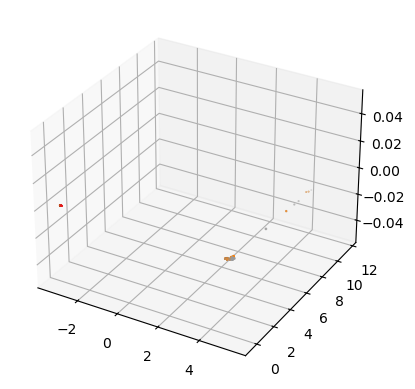

In [109]:
from sklearn.decomposition import PCA

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
pca.fit(X)

X_pca = pca.transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y, cmap='Set1')
plt.show()

In [110]:
# X = X_pca

## Dataset Splitting

In [111]:
# split based on random seed value

X, X_test_unseen = address.seed_split(X, seed_idx=test_idx, n_seeds=len(SEEDS), n_samples=99)

In [112]:
# add labels

y = list()
for model in MODELS:
    y += [model] * (99*(len(SEEDS)-1))
y = le.transform(y)

y_test_unseen = list()
for model in MODELS:
    y_test_unseen += [model] * 99
y_test_unseen = le.transform(y_test_unseen)

In [113]:
assert X.shape[0] == y.shape[0]

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## Utilities

In [115]:
from sklearn.model_selection import GridSearchCV

def print_grid_search_results(cv_results_):
    print(tabulate(np.column_stack([cv_results_['params'], cv_results_['mean_test_score'], cv_results_['rank_test_score']]), headers=['params', 'score', 'rank']))

In [116]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(clf, X_test, y_test):
    accuracy = accuracy_score(y_test, clf.predict(X_test))
    f1 = f1_score(y_test, clf.predict(X_test), average='macro')
    precision = precision_score(y_test, clf.predict(X_test), average='macro')
    recall = recall_score(y_test, clf.predict(X_test), average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

## $k$-NN

### Hyperparameter Tuning

In [117]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

params = {'n_neighbors': [1,3,5,10],
          'weights': ['uniform','distance'],
          'p': [1,2,3]}

clf = GridSearchCV(knn, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']})

In [118]:
print_grid_search_results(clf.cv_results_)

params                                                 score    rank
--------------------------------------------------  --------  ------
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}    0.455634      19
{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}   0.455634      19
{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}    0.448898      23
{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}   0.448898      23
{'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}    0.448905      21
{'n_neighbors': 1, 'p': 3, 'weights': 'distance'}   0.448905      21
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}    0.522974       8
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}   0.46127       16
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}    0.521882       9
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}   0.460159      18
{'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}    0.529722       7
{'n_neighbors': 3, 'p': 3, 'weights': 'distance'}   0.462388      15
{'n_neighbors': 5, 'p': 1, 'weight

### Training

In [119]:
knn = KNeighborsClassifier(n_neighbors=10,
                           p=1,
                           weights='uniform')

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=1)

### Evaluation

In [120]:
evaluate(knn, X_train, y_train)

Accuracy: 0.6958473625140292
F1: 0.6868453928224622
Precision: 0.6925102780317655
Recall: 0.6958473625140291


In [121]:
evaluate(knn, X_test, y_test)

Accuracy: 0.569023569023569
F1: 0.5436404690779927
Precision: 0.5350114981675036
Recall: 0.5690235690235691


In [122]:
evaluate(knn, X_test_unseen, y_test_unseen)

Accuracy: 0.3333333333333333
F1: 0.17368421052631577
Precision: 0.11743772241992882
Recall: 0.3333333333333333


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## DT

### Hyperparameter Tuning

In [123]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

params = {'criterion': ['gini','entropy','log_loss'],
          'splitter': ['best', 'random'],
          'random_state': [42]}

clf = GridSearchCV(dt, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'random_state': [42], 'splitter': ['best', 'random']})

In [124]:
print_grid_search_results(clf.cv_results_)

params                                                                  score    rank
-------------------------------------------------------------------  --------  ------
{'criterion': 'gini', 'random_state': 42, 'splitter': 'best'}        0.474741       1
{'criterion': 'gini', 'random_state': 42, 'splitter': 'random'}      0.461277       4
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'best'}     0.463493       2
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'random'}   0.46127        5
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'best'}    0.463493       2
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'random'}  0.46127        5


### Training

In [125]:
dt = DecisionTreeClassifier(criterion='entropy',
                            random_state=42,
                            splitter='random')

dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42, splitter='random')

### Evaluation

In [126]:
evaluate(dt, X_test, y_test)

Accuracy: 0.4107744107744108
F1: 0.4104055976405841
Precision: 0.41258794845001745
Recall: 0.41077441077441074


In [127]:
evaluate(dt, X_test_unseen, y_test_unseen)

Accuracy: 0.21548821548821548
F1: 0.12475633528265107
Precision: 0.08779149519890261
Recall: 0.2154882154882155


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## RF

### Hyperparameter Tuning

In [128]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

params = {'n_estimators': [1, 5, 10, 25, 50, 100, 250, 500, 1000],
          'criterion': ['gini','entropy','log_loss'],
          'random_state': [42]}

# clf = GridSearchCV(rf, params, cv=5)
# clf.fit(X_train, y_train)

In [129]:
print_grid_search_results(clf.cv_results_)

params                                                                  score    rank
-------------------------------------------------------------------  --------  ------
{'criterion': 'gini', 'random_state': 42, 'splitter': 'best'}        0.474741       1
{'criterion': 'gini', 'random_state': 42, 'splitter': 'random'}      0.461277       4
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'best'}     0.463493       2
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'random'}   0.46127        5
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'best'}    0.463493       2
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'random'}  0.46127        5


### Training

In [130]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluation

In [131]:
evaluate(rf, X_test, y_test)

Accuracy: 0.41414141414141414
F1: 0.41555340806597085
Precision: 0.4170709570957096
Recall: 0.41414141414141414


In [132]:
evaluate(rf, X_test_unseen, y_test_unseen)

Accuracy: 0.32996632996632996
F1: 0.18300653594771243
Precision: 0.12661498708010335
Recall: 0.32996632996632996


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## MLP

### Hyperparameter Tuning

In [133]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

params = {'hidden_layer_sizes': [[i+1] for i in range(10)],
          'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['sgd', 'adam'],
          'learning_rate_init': [0.001, 0.005, 0.01],
          'max_iter': [1000, 2500, 5000],
          'momentum': [0.9, 0.99],
          'random_state': [42]}

# clf = GridSearchCV(mlp, params, cv=5)
# clf.fit(X_train, y_train)

In [134]:
print_grid_search_results(clf.cv_results_)

params                                                                  score    rank
-------------------------------------------------------------------  --------  ------
{'criterion': 'gini', 'random_state': 42, 'splitter': 'best'}        0.474741       1
{'criterion': 'gini', 'random_state': 42, 'splitter': 'random'}      0.461277       4
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'best'}     0.463493       2
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'random'}   0.46127        5
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'best'}    0.463493       2
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'random'}  0.46127        5


### Training

In [135]:
mlp = MLPClassifier(activation='identity',
                    hidden_layer_sizes=[2], 
                    learning_rate_init=0.01,
                    max_iter=2500, 
                    momentum=0.99,
                    random_state=42,
                    solver='sgd')

mlp.fit(X_train, y_train)

MLPClassifier(activation='identity', hidden_layer_sizes=[2],
              learning_rate_init=0.01, max_iter=2500, momentum=0.99,
              random_state=42, solver='sgd')

### Evaluation

In [136]:
evaluate(mlp, X_test, y_test)

Accuracy: 0.6531986531986532
F1: 0.6228418607286531
Precision: 0.6337885243937916
Recall: 0.6531986531986532


In [137]:
evaluate(mlp, X_test_unseen, y_test_unseen)

Accuracy: 0.3333333333333333
F1: 0.16666666666666666
Precision: 0.1111111111111111
Recall: 0.3333333333333333


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Training

In [138]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()

sgd.fit(X_train, y_train)

SGDClassifier()

In [139]:
evaluate(sgd, X_test, y_test)

Accuracy: 0.6565656565656566
F1: 0.5284628099173554
Precision: 0.44231927013383965
Recall: 0.6565656565656566


In [140]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log_loss')

sgd.fit(X_train, y_train)

SGDClassifier(loss='log_loss')

In [141]:
evaluate(sgd, X_test, y_test)

Accuracy: 0.6127946127946128
F1: 0.5730421330874377
Precision: 0.563066319645267
Recall: 0.6127946127946128


In [150]:
evaluate(sgd, X_test_unseen, y_test_unseen)

Accuracy: 0.31986531986531985
F1: 0.17935399636693916
Precision: 0.1386601475381712
Recall: 0.3198653198653199


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [147]:
from sklearn.svm import SVC

svc = SVC()

In [148]:
svc.fit(X_train, y_train)
evaluate(svc, X_test, y_test)

Accuracy: 0.6666666666666666
F1: 0.5333877551020408
Precision: 0.4445704436178899
Recall: 0.6666666666666666


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [149]:
evaluate(svc, X_test_unseen, y_test_unseen)

Accuracy: 0.3333333333333333
F1: 0.16666666666666666
Precision: 0.1111111111111111
Recall: 0.3333333333333333


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
